COVID GDP
==========

This notebook explores the relationship betwen COVID-19 cases and GDP 

# Define general variables

In [163]:
""" Load modules """
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math

# Input data

## Covid incidence and GDP data from Our World in Data

In [164]:
""" Data file """
data_file = 'owd-data-total-covid_19_incidence_gdp_per_capita-20210130.csv'
file_path = '../data/' + data_file

In [165]:
""" Load GDP and covid data """
data = pd.read_csv(file_path)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [166]:
""" Rename data variables """
data.columns = ['country', 'code', 'year', 'continent', 'gdp', 'date', 'incidence', 'notes']

In [167]:
""" Check data """
data.head()

,country,code,year,continent,gdp,date,incidence,notes
0,Abkhazia,OWID_ABK,2015.0,Asia,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2002.0,NaN,1063.635574,NaN,NaN,NaN
2,Afghanistan,AFG,2003.0,NaN,1099.194507,NaN,NaN,NaN
3,Afghanistan,AFG,2004.0,NaN,1062.249360,NaN,NaN,NaN
4,Afghanistan,AFG,2005.0,NaN,1136.123214,NaN,NaN,NaN


In [168]:
""" Remove entries with no country code (continents and special locations)"""
data.dropna(subset=['code'], inplace=True)

In [169]:
""" Extract country names """
countries = data.loc[:, ['country', 'code']].drop_duplicates().set_index('code')

In [170]:
""" Extract DGP per capital data """
gdp_data = data.loc[data.loc[:, 'gdp'].notnull(), ['code', 'year', 'gdp']].copy()
gdp_data.head()

,code,year,gdp
1,AFG,2002.0,1063.635574
2,AFG,2003.0,1099.194507
3,AFG,2004.0,1062.249360
4,AFG,2005.0,1136.123214
5,AFG,2006.0,1161.124889


In [171]:
""" Reshape GDP data by annual value """
gdp_annual = gdp_data.pivot(index='code', columns='year', values='gdp')
gdp_annual.head()

year,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
code,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35973.780510,NaN,NaN,NaN,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1298.143159,1531.173993,1614.255001,1660.739856,1839.273579,1848.700026,1838.960244,1809.016488,1802.695565,1803.987487
AGO,3430.798427,3359.374794,3062.042696,2252.051608,2210.066786,2465.396619,2720.521329,2839.758717,2893.334472,2873.883924,...,5978.323249,5908.042248,5897.682841,5911.254092,5999.902106,6188.003756,6257.152874,6227.664689,5972.451513,5819.494971
ALB,4722.838166,3345.504049,3123.512503,3444.321792,3753.169904,4278.689663,4697.153233,4214.358153,4623.026401,5280.527867,...,9153.788206,9524.649303,9927.181841,10207.764699,10369.823382,10492.806283,10701.120786,10970.452245,11356.341329,11803.430594
ARE,110432.464979,105171.409619,102615.170342,98224.516475,99529.780723,100976.945075,101754.295698,104829.027296,100018.103764,97753.828420,...,71314.668819,60769.861028,57232.618076,58363.678216,59419.089491,61688.380299,63943.185829,66569.403414,67705.949329,67293.482759


In [172]:
""" Extract covid incidence data """
covid_data = data.loc[data.loc[:, 'incidence'].notnull(), ['code', 'date', 'incidence']].copy()
covid_data.head()

,code,date,incidence
17,AFG,2020-02-24,0.026
18,AFG,2020-02-25,0.026
19,AFG,2020-02-26,0.026
20,AFG,2020-02-27,0.026
21,AFG,2020-02-28,0.026


In [173]:
covid_daily = covid_data.pivot(index='code', columns='date', values='incidence')
covid_daily.head()

date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-01-20,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29
code,,,,,,,,,,,,,,,,,,,,,
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1394.306,1397.517,1399.572,1401.524,1402.449,1404.427,1406.430,1409.102,1410.052,1411.285
AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,580.930,583.486,586.285,589.267,590.240,592.583,594.926,595.748,598.547,600.099
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24059.351,24294.948,24551.741,24824.866,25114.323,25301.272,25606.713,25911.113,26219.334,26530.683
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120468.517,121387.433,121866.304,122940.529,123587.653,124195.949,124739.533,125749.045,126564.421,127315.084
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404,0.404,0.404,...,26665.150,27021.961,27381.097,27741.648,28103.515,28466.594,28830.684,29228.949,29629.944,30030.535


From this data, it seems that all countries have been touched by covid since January 21, 2021. To be further investigated with plot

On January 20, 2021, the Federal States of Micronesia was the last state to publically declare existing cases of COVID-19 on its territory.

In [197]:
""" Select day of refence for COVID count """
date = '2021-01-28'
covid_variable = covid_daily.loc[:, date]
covid_variable = np.log(covid_variable)
covid_variable.name = 'covid'

In [198]:
""" Select year of reference for GDP """
year = 2017
gdp_variable = gdp_annual.loc[:, year]
gdp_variable = np.log(gdp_variable)
gdp_variable.name = 'gdp'

In [199]:
""" Continent data """
continents = data.loc[:, ['code', 'continent']].dropna().set_index('code')
continents.head()

,continent
code,
OWID_ABK,Asia
AFG,Asia
OWID_AKD,Asia
ALB,Europe
DZA,Africa


In [208]:
model_data = pd.concat([gdp_variable, covid_variable, continents], axis=1).copy()
model_data = model_data.dropna(axis=0).copy()

## Plot scatter of GDP / COVID and polynomial regression model

In [221]:
""" Generate subplot data (continents) """
subplot_data = {}

for continent in model_data['continent'].unique():
    subplot_data[continent] = model_data.loc[model_data.loc[:, 'continent']==continent]

In [222]:
def plot_model(data, scatter, label, color, linewidth, alpha, ax):
    """ 
    Plot regression model and data scatter
    """
    # Compute model
    x = np.array(data.loc[:, 'gdp'])
    y = np.array(data.loc[:, 'covid'])
    mymodel = np.poly1d(np.polyfit(x, y, 1))
    vmin, vmax = x.min()-.2, x.max()+.2
    
    # Define model line
    myline = np.linspace(vmin, vmax, 100)
    
    
    # Plot scatter
    if scatter == True:
        if color == False:
            ax.scatter(x, y)
        else:
            ax.scatter(x, y, c=color, alpha=alpha+.2)
    else:
        pass
    
    # Plot scatter labels
    if label == True:
        for i, txt in enumerate(data.index):
            ax.annotate(txt, (x[i], y[i]), alpha=0.5)
            
    # Relabel scale with non-log values
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    plt.yticks(np.log([10, 100, 1000, 10000, 100000]),
               ['10', '100', '1,000', '10,000', '100,000'])
    plt.xticks(np.log([1000, 2000, 5000, 10000, 20000, 50000, 100000]),
           ['1,000', '2,000', '5,000', '10,000', '20,000', '50,000', '100,000'])
    
    # Plot
    if color==False:
        plt.plot(myline, mymodel(myline), linewidth=linewidth, alpha=alpha)
    else:
        plt.plot(myline, mymodel(myline), c=color, linewidth=linewidth, alpha=alpha)

In [223]:
""" Set color codes """
colors = {'World':'purple',
          'Asia':'dodgerblue',
          'Africa':'red',
          'Europe':'green',
          'North America':'orange',
          'South America':'brown',
          'Oceania':'darkkhaki'}

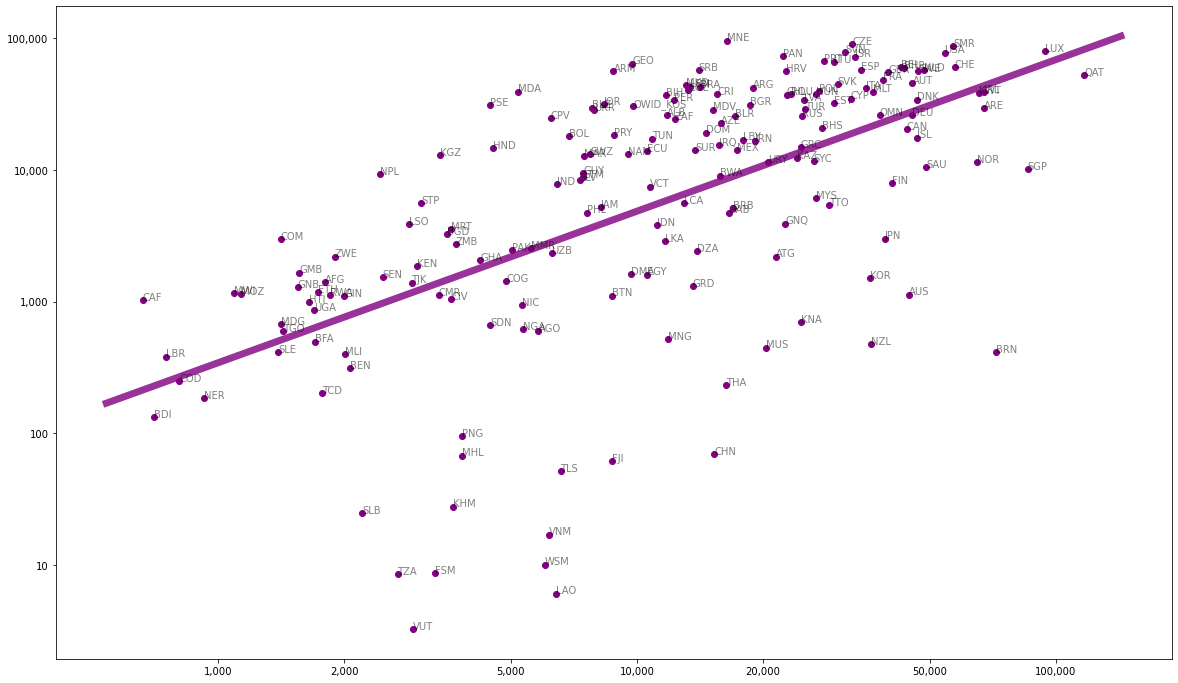

In [224]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plost model on world set
plot_model(model_data, scatter=True, label=True, color=colors['World'], linewidth=7, alpha=0.8, ax=ax)

plt.show()

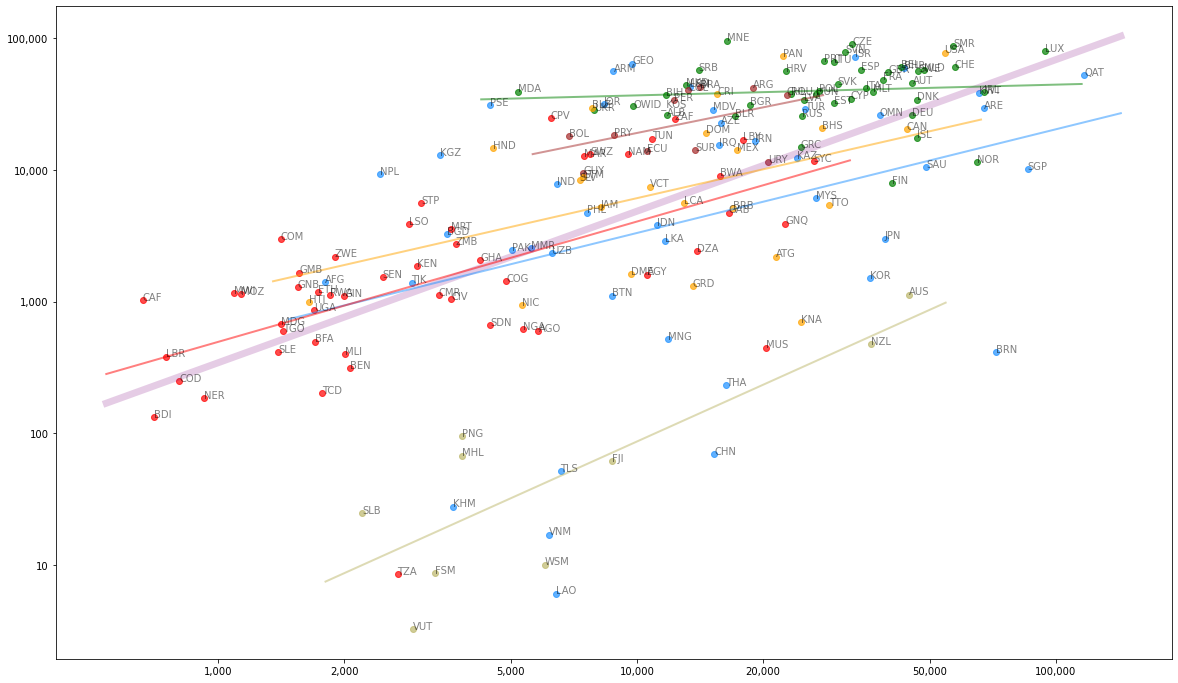

In [225]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot model on world set
plot_model(model_data, scatter=False, label=False, color=colors['World'], linewidth=7, alpha=0.2, ax=ax)

# Plot model on continental sets
for continent in subplot_data:
    df = subplot_data[continent]
    plot_model(df, scatter=True, label=True, color=colors[continent], linewidth=2, alpha=0.5, ax=ax)

plt.show()

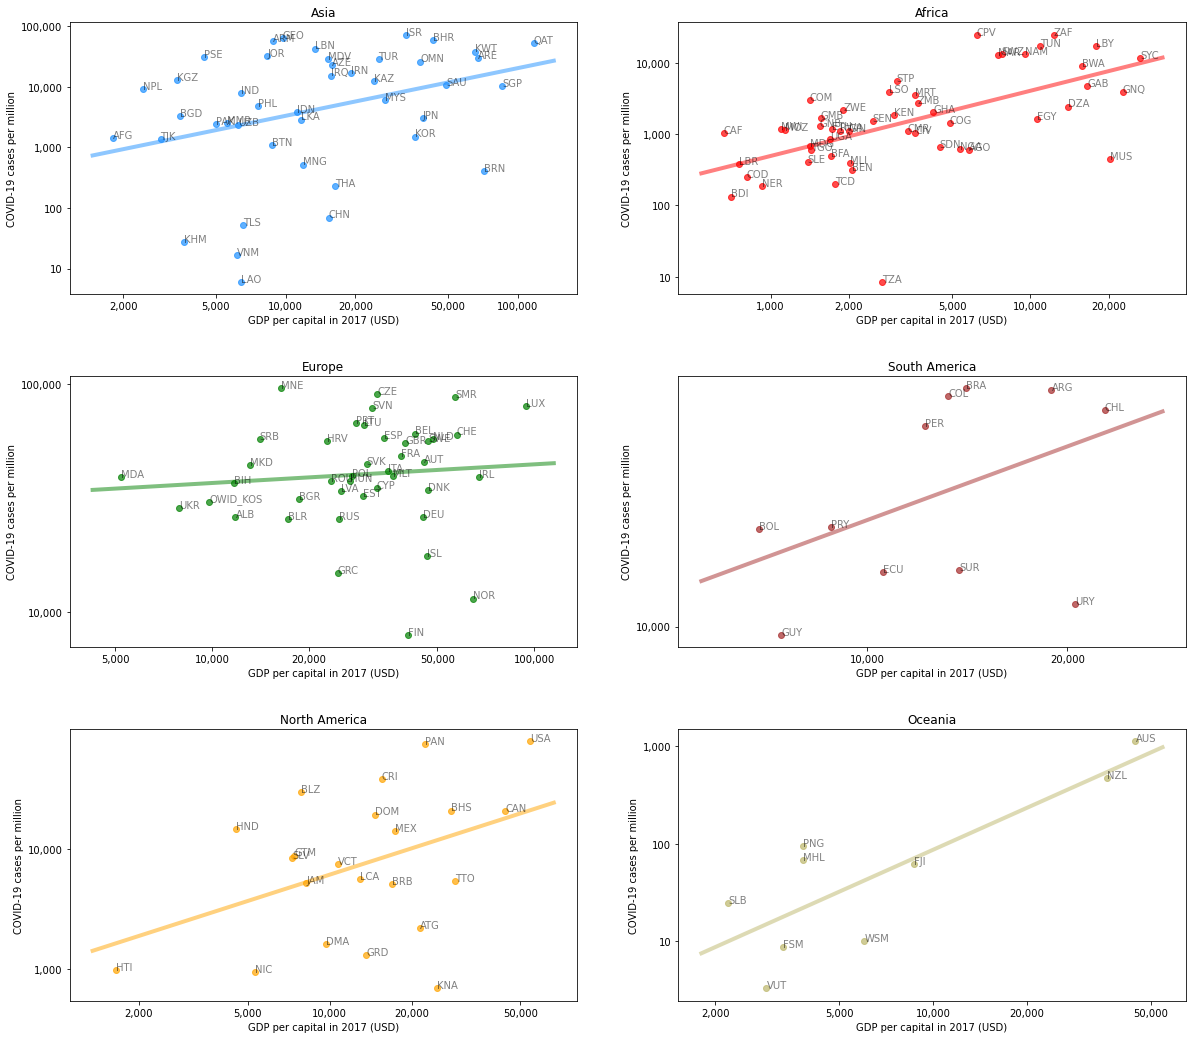

In [226]:
""" Plot continental models """
# Define ax locations
ax_locs = [[0,0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]

fig, axs = plt.subplots(3, 2, figsize=(20, 18))

for i, continent in enumerate(subplot_data.keys()):
    ax = plt.subplot(axs[ax_locs[i][0], ax_locs[i][1]])
    data = subplot_data[continent]   
    plot_model(data, scatter=True, label=True, color=colors[continent], linewidth=4, alpha=0.5, ax=ax)
    ax.set(title=continent, xlabel='GDP per capital in 2017 (USD)', ylabel='COVID-19 cases per million')
    
plt.subplots_adjust(hspace=0.3)

plt.show()

## Plot linear model for Asia sub-continental regions
To present after statistical value tables of continental regions

In [228]:
asia_data_path = '../data/koseki-data-countries_asia-20211231.csv'
asia_data = pd.read_csv(asia_data_path, index_col=0)

In [229]:
asia_subcontinents = {} 
for subcontinent in asia_data.loc[:, 'subcontinent'].unique():
    idx = asia_data.loc[asia_data.loc[:, 'subcontinent']==subcontinent].index
    asia_subcontinents[subcontinent] = subplot_data['Asia'].loc[idx]

In [230]:
""" Set Asia subcolors """
asiacolors = {'central':'deepskyblue', 'western':'steelblue', 'eastern':'lightblue'}

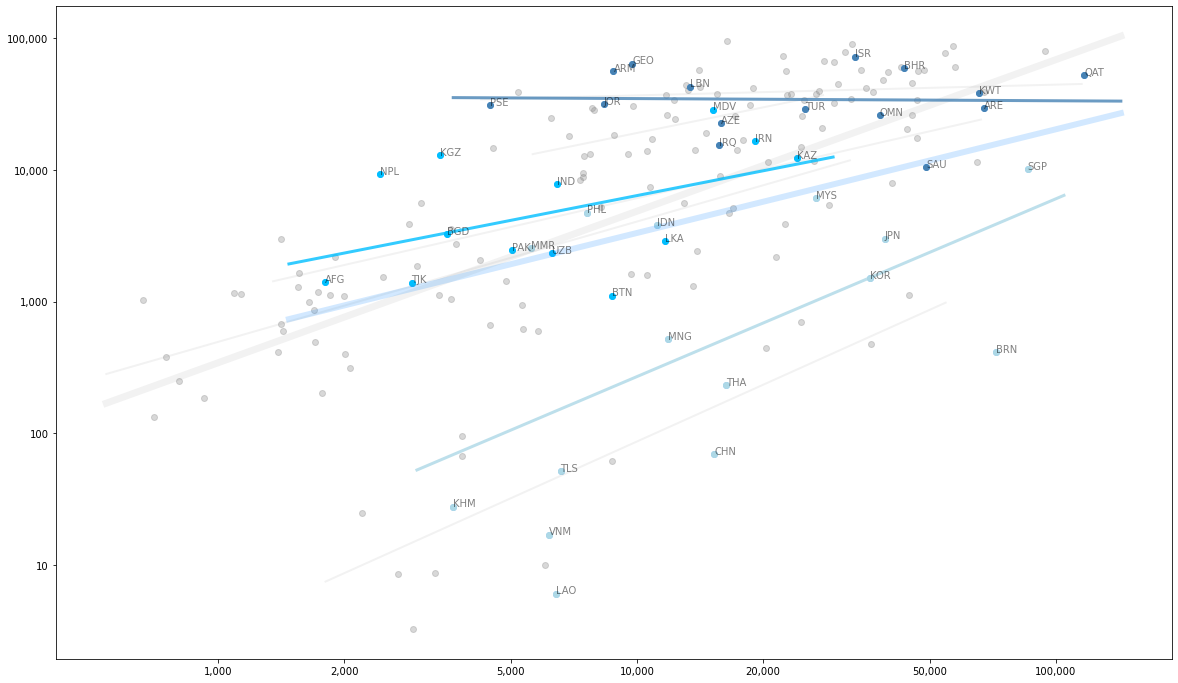

In [231]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot model on world set
plot_model(model_data, scatter=False, label=False, color='grey', linewidth=7, alpha=0.1, ax=ax)

# Plot model on continental sets
for continent in subplot_data:
    if continent != 'Asia':
        df = subplot_data[continent]
        plot_model(df, scatter=True, label=False, color='grey', linewidth=2, alpha=0.1, ax=ax)
        
df = subplot_data['Asia']
plot_model(df, scatter=True, label=False, color=colors['Asia'], linewidth=6, alpha=0.2, ax=ax)
        
# Plot model on subcontinent Asia    
for subcontinent in asia_subcontinents:
    df = asia_subcontinents[subcontinent]
    plot_model(df, scatter=True, label=True, color=asiacolors[subcontinent], linewidth=3, alpha=0.8, ax=ax)

plt.show()

## Model attributes

In [263]:
def linear_regression_model(x, y):
    model = LinearRegression()
    model.fit(x, y)
    model = LinearRegression().fit(x, y)
    return model

In [264]:
def model_parameters(data):
    x = np.array(data.loc[:, 'gdp']).reshape((-1, 1))
    y = np.array(data.loc[:, 'covid'])

    model = linear_regression_model(x, y)
    r = model.score(x, y)
    c = model.coef_[0]
    i = model.intercept_
    
    return ['%.4f' % x for x in [r, c, i]]

In [265]:
""" Output model attributes for World model """
d = {'World':model_parameters(model_data)}
world_model = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
world_model.to_csv('../figures/koseki-table-covid_gdp_world_model.csv')

# Show table
world_model

,r2,slope,intercept
World,0.3583,1.1513,-2.1150


In [240]:
""" Output model attributes for Continental models """
d = {}
for continent in subplot_data.keys():
    df = subplot_data[continent]
    d[continent]=model_parameters(df)

continental_models = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
continental_models.to_csv('../figures/koseki-table-covid_gdp_continental_models.csv')

# Show table
continental_models

,r2,slope,intercept
Asia,0.1193,0.7877,0.8534
Africa,0.3613,0.9142,-0.1120
Europe,0.0087,0.0816,9.7628
South America,0.1994,0.6459,3.9084
North America,0.1737,0.7270,2.0218
Oceania,0.6775,1.4313,-8.7211


In [241]:
""" Sub-continental regressions (Asia) """
d = {}
for subcontinent in asia_subcontinents:
    df = asia_subcontinents[subcontinent]
    d[subcontinent]=model_parameters(df)
    
asian_models = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
asian_models.to_csv('../figures/koseki-table-covid_gdp_asian_models.csv')

# Show table
asian_models

,r2,slope,intercept
central,0.2292,0.6250,3.0060
western,0.0008,-0.0167,10.6119
eastern,0.3009,1.3507,-6.8430


In [242]:
eastern_asia_idx = list(asia_subcontinents['eastern'].index)
oceania_idx = list(regression_data[regression_data.loc[:, 'continent']=='Oceania'].index)

In [247]:
filtered_regression_data = model_data.loc[~model_data.index.isin(eastern_asia_idx+oceania_idx)]

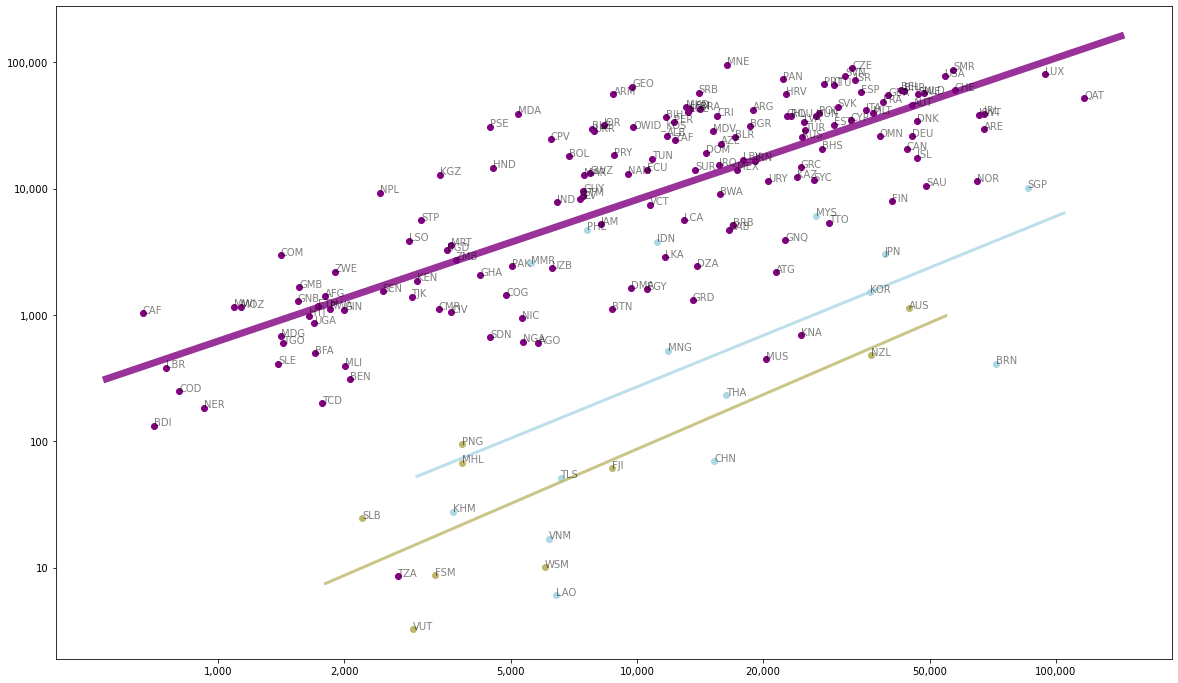

In [249]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot model of world minus oceania and eastern asia countries
plot_model(filtered_regression_data, scatter=True, label=True, color=colors['World'], linewidth=7, alpha=0.8, ax=ax)

# Plot model of oceania countries
plot_model(model_data.loc[oceania_idx], scatter=True, label=True, color=colors['Oceania'], linewidth=3, alpha=0.8, ax=ax)

# Plot model of oceania countries
plot_model(model_data.loc[eastern_asia_idx], scatter=True, label=True, color=asiacolors['eastern'], linewidth=3, alpha=0.8, ax=ax)

plt.show()

In [250]:
""" Output model attributes for World model """
d = {'West of Himalayas':model_parameters(filtered_regression_data)}
world_model_filtered = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
world_model_filtered.to_csv('../figures/koseki-table-covid_gdp_world_model_filtered.csv')

# Show table
world_model_filtered

,r2,slope,intercept
West of Himalayas,0.5739,1.1207,-1.3124


## Models error values

In [268]:
""" Filtered World """
x = filtered_regression_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = filtered_regression_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = filtered_regression_data.loc[:,'covid']

filtered_world_error = true_y - model_y

filtered_world_error

AFG    0.160980
AGO   -2.008490
ALB    0.978716
ARE   -0.849789
ARG    0.924119
         ...   
UZB   -0.722593
VCT   -0.171875
ZAF    0.854614
ZMB    0.022474
ZWE    0.546225
Name: covid, Length: 153, dtype: float64

In [270]:
""" Oceania """
x = oceania_regression_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = oceania_regression_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = oceania_regression_data.loc[:,'covid']

oceania_error = true_y - model_y

oceania_error

AUS    0.425739
FJI   -0.146542
FSM   -0.712299
MHL    1.128912
NZL   -0.129316
PNG    1.469280
SLB    0.910173
VUT   -1.520491
WSM   -1.425457
Name: covid, dtype: float64

In [271]:
""" Eastern Asia """
eastern_regression_data = model_data.loc[eastern_asia_idx].copy()

x = eastern_regression_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = eastern_regression_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = eastern_regression_data.loc[:,'covid']

eastern_error = true_y - model_y

eastern_error

BRN   -2.240007
CHN   -1.933666
IDN    2.492735
JPN    0.574313
KHM   -0.912695
KOR   -0.005163
LAO   -3.193903
MMR    3.034973
MNG    0.431739
MYS    1.791089
PHL    3.237948
SGP    0.730035
THA   -0.806588
TLS   -1.086561
VNM   -2.114251
Name: covid, dtype: float64

## Map regressions square errors

In [272]:
import geopandas

ModuleNotFoundError: No module named 'geopandas'